In [1]:
# !pip install scipy
# !pip install ruptures

# imports

In [1]:
import pandas as pd
from scipy.io import arff
import matplotlib.pyplot as plt
import numpy as np
import ruptures as rpt


# Dataset loading

In [4]:
filepath = './datasets/basic_motions/BasicMotions_TRAIN.arff'

def load_dataset_to_dataframe(path):
    """Load data that is stored within the path

    Args:
        path: string with path containing data
    Returns:
        A pandas dataframe with only data inside
    """
    dataset = arff.loadarff(path)
    df = pd.DataFrame(dataset[0])
    return df 

df = load_dataset_to_dataframe(filepath)


# Clear segementation off dataset 

In [ ]:
def stack_time_series(df):
    """This function creates new dataframe without segmentation and classification

    Args:
        df: segmented dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
    """
    dimensionality = df.iloc[0,0].shape[0] if type(df.iloc[0,0][0]) == np.void else 1  # assumption that data dimensionality is the number of rows of first element in dataframe
    # also the first column is expected to store data (second stores classification)
    chunk_size = len(df.iloc[0,0][0])
    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))
    
    # filling it with empty numpy arrays
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])
    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        if type(row[0][0]) == np.void:
            for r in row[0]:
                #print((type(r))==np.void)
                stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
                i += 1
        else:
             stacked.iloc[0,0] = np.concatenate((stacked.iloc[i,0],row[0]))
    return stacked


def dataframe_to_ndarray(df):
    """This function creates ndarray(2 dmiensional, shape: length x dim) of dataframe (shape: dim x length)

    Args:
        df: dataframe
    Returns:
        A numpy array with shape: length x dim)
    """
    ndarray = np.array([])
    for index, row in df.iterrows():
        if index == 0:
            ndarray = row[0]
        else:
            ndarray = np.vstack((ndarray,row[0]))
    return ndarray.transpose()

random_stacked, change_points = stack_time_series_randomly(df,True)
random_stacked = dataframe_to_ndarray(random_stacked)





stacked = stack_time_series(df)

fig, axs = plt.subplots(2, 3, figsize=(15, 10))

# Plot different data on each subplot
axs[0, 0].plot(stacked.iloc[0,0])
axs[0, 0].set_title('accelerometer X')

axs[0, 1].plot(stacked.iloc[1,0])
axs[0, 1].set_title('accelerometer Y')

axs[0, 2].plot(stacked.iloc[2,0])
axs[0, 2].set_title('accelerometer Z')

axs[1, 0].plot(stacked.iloc[3,0])
axs[1, 0].set_title('gyroscope X')

axs[1, 1].plot(stacked.iloc[4,0])
axs[1, 1].set_title('gyroscope Y')

axs[1, 2].plot(stacked.iloc[5,0])
axs[1, 2].set_title('gyroscope Z')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

n, dim = 4000, 6  # number of samples, dimension
n_bkps, sigma = 3, 5  # number of change points, noise standart deviation
signal, bkps = rpt.pw_constant(n, dim, n_bkps, noise_std=sigma)
# print((signal))
# print((signal).shape)

# plt.plot(signal)
# plt.show()

motion_basics_stacked_ndarray = dataframe_to_ndarray(stacked)

# plt.plot(motion_basics_stacked_ndarray)
# plt.show()

# # change point detection
# model = "l2"  # "l1", "rbf", "linear", "normal", "ar"
# algo = rpt.Window(model=model).fit(motion_basics_stacked_ndarray)

# my_bkps = algo.predict(n_bkps=3)

# rpt.show.display(motion_basics_stacked_ndarray, bkps, my_bkps, figsize=(10, 6))
# plt.show()

# Evaluation 

In [219]:
# https://ceur-ws.org/Vol-1226/paper31.pdf

def points_labels_vector(n,change_points):
    """This function creates vector of predicated labels [0,0, ...,1,...0] 
    where 1 means time series at this index is change point, and 0 that there is no change point

    Args:
        n: count of time series
        change_points: 1-D numpy array with change point indexes
    Returns:
        A 1-D numpy array with lenght of n, containing ones and zeros
    """
    predicted_labels = np.zeros(n)
    predicted_labels[change_points] = 1
    return predicted_labels


def calculate_TP_TN_FP_FN(n, predicted_points, original_points, treshold):
    """This function calculates TP, TN, FP, FN , the change point is correct if its distance from original
    change point is closer then treshold, when there is more than one change point within the threshold the additional
    ones are considered FP

    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        A scalar values of TP, TN, FP, FN
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    TP = 0
    TN = 0
    FP = 0
    FN = 0
    zone_counter = np.zeros(len(original_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                which_point = np.argmin(np.abs(original_points - index))
                #print(original_points)
                #print(which_point)
                if zone_counter[which_point] == True :
                    FP+=1
                else:
                    TP+=1     
                    zone_counter[which_point] = True
        else:
            if value == 0:
                TN+=1
            else:
                FP+=1

    for index , val in enumerate(zone_counter):
         if val == False:
             FN+=1

    return TP, TN, FP, FN
            


def calculate_ACC_PRE_REC_F1(TP,TN,FP,FN):
    A = (TP+TN)/(TP+TN+FP+FN)
    P = TP/(TP+FP)
    R = TP/(TP+FN)
    F1 = (2*TP)/(2*TP+FN+FP)
    return A,P,R,F1


def calculateASC(n, predicted_points, original_points, treshold):
    """This function calculates average count of predicted change points in segmentation zone

    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        average change point count for segmentation zone 
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    sum = 0
    zone_counter = np.zeros(len(predicted_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                sum+=1
 
    return sum/len(original_points)

def calculateASD(n, predicted_points, original_points, treshold):
    """This function calculates average distance of predicted change points from the center of segmentation zone

    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        average distance 
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    ASD = 0
    div = 0
    zone_counter = np.zeros(len(predicted_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                ASD += np.min(np.abs(original_points - index))
                div += 1
 
    return (ASD/div) if div > 0 else -1


def calculateADT(n, predicted_points, original_points, treshold):
    """This function calculates average direction tendency, above 0.5 means that algorithm tends to place change points after
        segmentation zone center. Value below 0.5 means the tendency is to put change points before segmentation zone center
    Args:
        n: count of time series
        predicted_points: 1-D numpy array with predicted change point indexes
        original_points: 1-D numpy array with original change point indexes
        treshold: arbitray distance from orignal point
    Returns:
        average direction tendency
    """
    predicted_labels = points_labels_vector(n, predicted_points)
    original_labels = points_labels_vector(n, original_points)

    PostSeg = 0
    PreSeg = 0
    zone_counter = np.zeros(len(predicted_points), dtype=bool)
    for index, value in enumerate(predicted_labels):
        if(np.min(np.abs(original_points - index)) < treshold):
            if value == 1:
                arg = np.argmin(np.abs(original_points - index))
                if index > original_points[arg]:
                    PostSeg += 1
                else:
                    PreSeg += 1
 
    return (PostSeg/(PostSeg+PreSeg)) if (PostSeg+PreSeg) > 0 else -1


def predict_change_points(data,n,original_points,cost_function):
    algo = rpt.BottomUp(model=cost_function)
    algo.fit(data)
    print( len(original_points))
    result = algo.predict(n_bkps = len(original_points))

    prediction_margin =( n/len(original_points)/8)
    print(prediction_margin)
    print(result)
    TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result[:-1],original_points,prediction_margin)
    ASC = calculateASC(n,result[:-1],original_points,prediction_margin)
    ASD = calculateASD(n,result[:-1],original_points,prediction_margin)
    ADT = calculateADT(n,result[:-1],original_points,prediction_margin)
    
    Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)
    
    score = ScoreRegimes(result[:-1],original_points,n)
        
        # Dane
    etykiety = ["Score","Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
    wartosci = [score,Acc, Prec, Recall, F1 , ASC , ASD, ADT]
        
        # Tworzenie DataFrame
    evaluation = pd.DataFrame({
            "Metryka": etykiety,
            "Wartość": wartosci
    })
    return evaluation, result


def predict_change_points_binseg(data,n,original_points):
    algo = rpt.Binseg(model="linear")
    algo.fit(data)
    print( len(original_points))
    result = algo.predict(n_bkps = len(original_points))

    prediction_margin =( n/len(original_points)/4)
    print(prediction_margin)
    print(result)
    TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result[:-1],original_points,prediction_margin)
    ASC = calculateASC(n,result[:-1],original_points,prediction_margin)
    ASD = calculateASD(n,result[:-1],original_points,prediction_margin)
    ADT = calculateADT(n,result[:-1],original_points,prediction_margin)
    
    Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)
    
    
    # Dane
    etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
    wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]
    
    # Tworzenie DataFrame
    evaluation = pd.DataFrame({
        "Metryka": etykiety,
        "Wartość": wartosci
    })
    return result, evaluation

def predict_change_points_window(data,n,original_points):
    algo = rpt.Window(model="linear")
    algo.fit(data)
    print( len(original_points))
    result = algo.predict(n_bkps = len(original_points))

    prediction_margin =( n/len(original_points)/4)
    print(prediction_margin)
    print(result)
    TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result[:-1],original_points,prediction_margin)
    ASC = calculateASC(n,result[:-1],original_points,prediction_margin)
    ASD = calculateASD(n,result[:-1],original_points,prediction_margin)
    ADT = calculateADT(n,result[:-1],original_points,prediction_margin)
    
    Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)
    
    
    # Dane
    etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
    wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]
    
    # Tworzenie DataFrame
    evaluation = pd.DataFrame({
        "Metryka": etykiety,
        "Wartość": wartosci
    })
    return result, evaluation

# Randomize dataframe rows

In [8]:
def stack_time_series_randomly(df,opt):
    """This function creates new dataframe without segmentation and classification, what is more its rows are randomly shuffled

    Args:
        df: segmented dataframe
        seed: this value is being passed to the sample function which shuffles rows in dataframe
    Returns:
        A pandas dataframe with shape [dimensions of input data,original count of time series]
        , numpy array containing change points
    """
    print( df.iloc[0,0].shape)
    dimensionality = df.iloc[0,0].shape[0] if type(df.iloc[0,0][0]) == np.void else 1  # assumption that data dimensionality is the number of rows of first element in dataframe
    
    change_points = np.array([],dtype=int)
    chunk_size = len(df.iloc[0,0][0])

    # creating new data frame 
    stacked = pd.DataFrame(index=np.arange(dimensionality), columns=np.arange(1))

    # randomize rows
    if(opt == True):
        df = df.sample(frac=1, random_state=43).reset_index(drop=True)
    # filling it with empty numpy arrays
    print(dimensionality)
    for i in range(dimensionality):
        stacked.iloc[i, 0] = np.array([])

    last_class = df.iloc[0,1]
    # filling the dataframe with data    
    for index, row in df.iterrows():
        i = 0
        if last_class != row[1]:
            change_points = np.append(change_points,int(index*chunk_size))
        last_class = row[1]
        if type(row[0][0]) == np.void:
            for r in row[0]:
                #print((type(r))==np.void)
                stacked.iloc[i,0] = np.concatenate((stacked.iloc[i,0],np.array(r.tolist())))
                i += 1
        else:
             stacked.iloc[0,0] = np.concatenate((stacked.iloc[i,0],row[0]))
    return stacked, change_points

# random_stacked, change_points = stack_time_series_randomly(df,True)
# random_stacked = dataframe_to_ndarray(random_stacked)

# plt.plot(random_stacked)
# plt.show()
# shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)
# print("\nPomieszany DataFrame:")
#print(random_stacked)

# Ruptures - BottomUp

In [ ]:
algo = rpt.BottomUp(model="normal")
algo.fit(random_stacked)
result = algo.predict(n_bkps = 34)
# plt.plot(random_stacked)
# print(result)


plt.figure(figsize=(12, 6))
plt.plot(random_stacked)

# Dodawanie pionowych linii w punktach z result
for idx in result:
    plt.axvline(x=idx, color='r', linestyle='--', label='Segment Change' if idx == result[0] else "")

# Ustawienie legendy
plt.legend()

# Wyświetlanie wykresu
plt.xlabel('Indeks')
plt.ylabel('Wartość')
plt.title('Wykres z pionowymi liniami w punktach zmiany segmentów')
plt.grid(True)
plt.show()

TP,TN,FP,FN = calculate_TP_TN_FP_FN(4000,result[:-1],change_points,50)
ASC = calculateASC(4000,result[:-1],change_points,50)
ASD = calculateASD(4000,result[:-1],change_points,50)
ADT = calculateADT(4000,result[:-1],change_points,50)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})

evaluation

# Ruptures - binarySeg

In [ ]:
algo = rpt.Binseg(model="normal")
algo.fit(random_stacked)
result = algo.predict(n_bkps = 34)
# plt.plot(random_stacked)
# print(result)


plt.figure(figsize=(12, 6))
plt.plot(random_stacked)

# Dodawanie pionowych linii w punktach z result
for idx in result:
    plt.axvline(x=idx, color='r', linestyle='--', label='Segment Change' if idx == result[0] else "")


for idx in change_points:
    plt.axvline(x=idx, color='g', linestyle=':', label='Original Change' if idx == result[0] else "")


# Ustawienie legendy
plt.legend()

# Wyświetlanie wykresu
plt.xlabel('Indeks')
plt.ylabel('Wartość')
plt.title('Wykres z pionowymi liniami w punktach zmiany segmentów')
plt.grid(True)
plt.show()

zone_size = 30

TP,TN,FP,FN = calculate_TP_TN_FP_FN(4000,result[:-1],change_points,zone_size)
ASC = calculateASC(4000,result[:-1],change_points,zone_size)
ASD = calculateASD(4000,result[:-1],change_points,zone_size)
ADT = calculateADT(4000,result[:-1],change_points,zone_size)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})

evaluation

# Ruptures - Pelt

In [ ]:
algo = rpt.Pelt(model="l2")
algo.fit(random_stacked)
result = algo.predict(pen=1100)
# plt.plot(random_stacked)
# print(result)


plt.figure(figsize=(12, 6))
plt.plot(random_stacked)

# Dodawanie pionowych linii w punktach z result
for idx in result:
    plt.axvline(x=idx, color='r', linestyle='--', label='Segment Change' if idx == result[0] else "")


for idx in change_points:
    plt.axvline(x=idx, color='g', linestyle=':', label='Original Change' if idx == result[0] else "")


# Ustawienie legendy
plt.legend()

# Wyświetlanie wykresu
plt.xlabel('Indeks')
plt.ylabel('Wartość')
plt.title('Wykres z pionowymi liniami w punktach zmiany segmentów')
plt.grid(True)
plt.show()

zone_size = 30

TP,TN,FP,FN = calculate_TP_TN_FP_FN(4000,result[:-1],change_points,zone_size)
ASC = calculateASC(4000,result[:-1],change_points,zone_size)
ASD = calculateASD(4000,result[:-1],change_points,zone_size)
ADT = calculateADT(4000,result[:-1],change_points,zone_size)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})

evaluation

# Ruptures - kernelcpd

In [ ]:
algo = rpt.KernelCPD()
algo.fit(random_stacked)
result = algo.predict(n_bkps = 34)
# plt.plot(random_stacked)
# print(result)


plt.figure(figsize=(12, 6))
plt.plot(random_stacked)

# Dodawanie pionowych linii w punktach z result
for idx in result:
    plt.axvline(x=idx, color='r', linestyle='--', label='Segment Change' if idx == result[0] else "")


for idx in change_points:
    plt.axvline(x=idx, color='g', linestyle=':', label='Original Change' if idx == result[0] else "")


# Ustawienie legendy
plt.legend()

# Wyświetlanie wykresu
plt.xlabel('Indeks')
plt.ylabel('Wartość')
plt.title('Wykres z pionowymi liniami w punktach zmiany segmentów')
plt.grid(True)
plt.show()

zone_size = 30

TP,TN,FP,FN = calculate_TP_TN_FP_FN(4000,result[:-1],change_points,zone_size)
ASC = calculateASC(4000,result[:-1],change_points,zone_size)
ASD = calculateASD(4000,result[:-1],change_points,zone_size)
ADT = calculateADT(4000,result[:-1],change_points,zone_size)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})

evaluation

In [ ]:
# import numpy as np
# from tslearn.hmm import GaussianHMM

# # Przykładowe dane
# X = np.array([[0.5], [1.0], [0.5], [1.0], [0.5]])

# # Utworzenie modelu HMM
# model = GaussianHMM(n_components=2, n_iter=100)

# # Dopasowanie modelu do danych
# model.fit(X)

# # Dekodowanie stanów ukrytych (segmentacja)
# logprob, states = model.decode(X, algorithm="viterbi")
# print("Log-probability:", logprob)
# print("Segmenty:", states)


# Claspy

In [ ]:
from claspy.segmentation import BinaryClaSPSegmentation
from claspy.data_loader import load_tssb_dataset

dataset, window_size, true_cps, time_series = load_tssb_dataset(names=("CricketX",)).iloc[0,:]
clasp = BinaryClaSPSegmentation()

help(rpt.Binseg )
help(algo.predict )
#clasp.fit_predict(random_stacked)


# Load 10 datasets

In [ ]:
from sktime.datasets import load_airline, load_basic_motions, load_arrow_head, load_gunpoint, load_osuleaf, load_italy_power_demand, load_shampoo_sales, load_longley, load_uschange, load_macroeconomic

# Wczytywanie 10 różnych zestawów danych
data1 = load_airline()
data2 = load_basic_motions(return_type="numpy3d")
data3 = load_arrow_head()
gun= load_gunpoint(split="Train",return_X_y=False )
data5 = load_osuleaf()
data6 = load_italy_power_demand()
data7 = load_shampoo_sales()
data8 = load_longley()
data9 = load_uschange()
data10 = load_macroeconomic()

#help(load_basic_motions)



print("-")
print(gun.iloc[0,1])
plt.plot(gun.iloc[0,0])
plt.show()
print("-")
print(gun.iloc[1,1])
plt.plot(gun.iloc[1,0])
plt.show()
print("-")
print(gun.iloc[3,1])
plt.plot(gun.iloc[3,0])
plt.show()

# gun_stacked, change_points = stack_time_series_randomly(gun,42,150)

# gun_stacked_ndarray = dataframe_to_ndarray(gun_stacked)

change_points = gun.iloc[:,1]

print(change_points)
ch = np.array([],dtype="int64")
l_c = change_points[0]
for i,p in change_points.items():
    if(l_c != p):
        ch = np.append(ch,int(i*150))
    l_c = p
change_points  = ch
gun_stacked = stack_time_series(gun,150)
gun_stacked_ndarray = dataframe_to_ndarray(gun_stacked)

# x = np.array(X_train).transpose()
print(change_points)
plt.plot(gun_stacked_ndarray[5100:5600])
#print(y_train)


In [ ]:
algo = rpt.BottomUp(model="normal")
algo.fit(gun_stacked_ndarray)
result = algo.predict(n_bkps = 34)
# plt.plot(random_stacked)
# print(result)
n = len(gun_stacked_ndarray)

TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result[:-1],change_points,50)
ASC = calculateASC(n,result[:-1],change_points,50)
ASD = calculateASD(n,result[:-1],change_points,50)
ADT = calculateADT(n,result[:-1],change_points,50)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})
#help(rpt.BottomUp)

rpt.display(gun_stacked_ndarray, change_points,result)
evaluation

# PenDigits

In [ ]:
filepath = './datasets/pen_digits/PenDigits_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
# print((df.iloc[1,0]))
# # print(len(df.iloc[1,0][0]))
# print((df.iloc[1,1]))
# print(df.shape)
pen_stacked , ch = stack_time_series(df,43,8)
pen_stacked_ndarray = dataframe_to_ndarray(pen_stacked)
# print(pen_stacked.shape)
# print(pen_stacked_ndarray)

#plt.plot(pen_stacked_ndarray[0:150])
# data = pen_stacked_ndarray[8:16]
# x = pen_stacked_ndarray[:, 0]
# y = pen_stacked_ndarray[:, 1]
# print(data)
# # Tworzenie wykresu
# plt.figure(figsize=(10, 6))  # Opcjonalnie, ustawienie rozmiaru wykresu
# plt.scatter(x, y, s=10)  # s=10 ustawia rozmiar punktów
# plt.xlabel('X axis')
# plt.ylabel('Y axis')
# plt.title('Scatter Plot of Points')
# plt.grid(True)
# plt.show()

algo = rpt.BottomUp(model="normal")
algo.fit(pen_stacked_ndarray)
result = algo.predict(n_bkps = len(ch))
# plt.plot(random_stacked)
# print(result)
n = len(pen_stacked_ndarray)
change_points = ch
TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result[:-1],change_points,50)
ASC = calculateASC(n,result[:-1],change_points,50)
ASD = calculateASD(n,result[:-1],change_points,50)
ADT = calculateADT(n,result[:-1],change_points,50)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})
#help(rpt.BottomUp)

rpt.display(pen_stacked_ndarray, ch,result)



# HearBeat

In [ ]:
filepath = './datasets/heart_beat/HeartBeat_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
# print((df.iloc[1,0]))
# # print(len(df.iloc[1,0][0]))
# print((df.iloc[1,1]))

# pen_stacked , ch = stack_time_series(df,43,8)
# pen_stacked_ndarray = dataframe_to_ndarray(pen_stacked)

In [ ]:

print((df))
print((df.iloc[0,1]))
print((df.iloc[0,0].shape))
print(len(df.iloc[0,0][0]))
heart_stacked , ch = stack_time_series_randomly(df,43,405)
heart_stacked_ndarray = dataframe_to_ndarray(heart_stacked)

#print(df.iloc[0,0][0])
print(heart_stacked_ndarray)
print(heart_stacked_ndarray.shape)

print(type(df.iloc[0,0][0]) == np.void)

In [ ]:
plt.plot(heart_stacked_ndarray[:,0])
print(ch)
rpt.display(heart_stacked_ndarray[:,0], ch)

In [ ]:
data = heart_stacked_ndarray[:,0]
algo = rpt.BottomUp(model="l1")
algo.fit(data)
result = algo.predict(n_bkps = len(ch))
# plt.plot(random_stacked)
# print(result)
n = 82620
change_points = ch
TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result[:-1],change_points,50)
ASC = calculateASC(n,result[:-1],change_points,50)
ASD = calculateASD(n,result[:-1],change_points,50)
ADT = calculateADT(n,result[:-1],change_points,50)


Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)


# Dane
etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]

# Tworzenie DataFrame
evaluation = pd.DataFrame({
    "Metryka": etykiety,
    "Wartość": wartosci
})
#help(rpt.BottomUp)

rpt.display(heart_stacked_ndarray[:,0], ch,result)
evaluation

# Cricket (tak)


In [ ]:
filepath = './datasets/Cricket/Cricket_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)

print(len(df.iloc[0,0][0]))

cricet_stacked,ch  = stack_time_series_randomly(df,False)
cricet_stacked_ndarray = dataframe_to_ndarray(cricet_stacked)

# #print(df.iloc[0,0][0])
# print(heart_stacked_ndarray)
print(cricet_stacked_ndarray.shape)
plt.plot(cricet_stacked_ndarray[:,0])
# print(type(df.iloc[0,0][0]) == np.void)
rpt.display(cricet_stacked_ndarray, ch)

In [ ]:
result,eval =  predict_change_points(cricet_stacked_ndarray,cricet_stacked_ndarray.shape[0],ch)
rpt.display(cricet_stacked_ndarray, ch,result)
eval


# Wine

In [ ]:
filepath = './datasets/Wine/Wine_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
# print(df.iloc[0,0])
# print(df)

# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*235))
    l_p = p

print(ndarray.flatten())
print(ndarray.flatten().shape)
print(change_points)
print(ch)
plt.plot(ndarray.flatten())


# WalkingSittingStanding

In [ ]:
filepath = './datasets/WalkingSittingStanding/WalkingSittingStanding_TEST.ts'

df = load_dataset_to_dataframe(filepath)

print(len(df.iloc[0,0][0]))

cricet_stacked,ch  = stack_time_series_randomly(df,False)
cricet_stacked_ndarray = dataframe_to_ndarray(cricet_stacked)

# #print(df.iloc[0,0][0])
# print(heart_stacked_ndarray)
print(cricet_stacked_ndarray.shape)
plt.plot(cricet_stacked_ndarray[:,0])
# print(type(df.iloc[0,0][0]) == np.void)
rpt.display(cricet_stacked_ndarray, ch)

# RacketSports

In [ ]:
filepath = './datasets/RacketSports/RacketSports_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)

print(len(df.iloc[0,0][0]))

cricet_stacked,ch  = stack_time_series_randomly(df,False)
cricet_stacked_ndarray = dataframe_to_ndarray(cricet_stacked)

print(ch)
print(len(ch))
print(cricet_stacked_ndarray.shape)
result,eval =  predict_change_points(cricet_stacked_ndarray,cricet_stacked_ndarray.shape[0],ch)
rpt.display(cricet_stacked_ndarray, ch,result)
eval

# Earthquakes (tak)

In [ ]:
filepath = './datasets/Earthquakes/Earthquakes_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
# print(df.iloc[0,0])

# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*512))
    l_p = p

rpt.display(ndarray.flatten(), change_points)

result,eval =  predict_change_points(ndarray.flatten(),len(ndarray.flatten()),change_points)
rpt.display(ndarray.flatten(), change_points,result)
eval

# UMD (tak)

In [ ]:
filepath = './datasets/UMD/UMD_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
print(df)
print(df.shape)

# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*150))
    l_p = p

rpt.display(ndarray.flatten(), change_points)

result,eval =  predict_change_points(ndarray.flatten(),len(ndarray.flatten()),change_points)
rpt.display(ndarray.flatten(), change_points,result)
eval

# SwedishLeaf(być może?)

         att1     att2      att3      att4      att5      att6      att7  \
0    1.524750  1.53812  1.410790  1.244400  1.039470  0.868676  0.664257   
1    2.214930  2.05051  1.842350  1.635900  1.432590  1.285370  1.143260   
2    1.872010  1.72637  1.573640  1.396900  1.252210  1.083760  0.955383   
3    1.731019  1.70220  1.553009  1.387209  1.144580  0.951378  0.733035   
4    1.842670  1.74943  1.593560  1.420510  1.268400  1.118720  0.972792   
..        ...      ...       ...       ...       ...       ...       ...   
495  1.555160  1.39118  1.027670  0.747651  0.425793  0.158014  0.152089   
496  1.823961  1.74961  1.579271  1.384801  1.204190  1.022790  0.876355   
497  2.009910  1.89306  1.711190  1.492730  1.312480  1.097560  0.949675   
498  1.474660  1.49555  1.358110  1.142910  0.906578  0.752583  0.985894   
499  2.021830  1.92956  1.740330  1.581830  1.428630  1.250230  1.103560   

         att8      att9     att10  ...    att120    att121    att122  \
0    0.489801  

(<Figure size 720x144 with 1 Axes>, [<Axes: >])

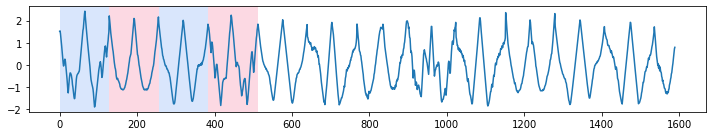

In [16]:
filepath = './datasets/SwedishLeaf/SwedishLeaf_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
print(df)
print(df.shape)

# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*128))
    l_p = p

rpt.display(ndarray.flatten()[0:1590], change_points[:4])

# result,eval =  predict_change_points(ndarray.flatten(),len(ndarray.flatten()),change_points)
# rpt.display(ndarray.flatten(), change_points,result)
# eval

# FreezerSmallTrain

In [ ]:
filepath = './datasets/FreezerSmallTrain/FreezerSmallTrain_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
print(df)
print(df.shape)

# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*301))
    l_p = p

print(change_points)
rpt.display(ndarray.flatten(), change_points)

result,eval =  predict_change_points(ndarray.flatten(),len(ndarray.flatten()),change_points)
rpt.display(ndarray.flatten(), change_points,result)
eval

# Libras (tak)

In [ ]:
filepath = './datasets/Libras/Libras_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)

print(len(df.iloc[0,0][0]))

cricet_stacked,ch  = stack_time_series_randomly(df,False)
cricet_stacked_ndarray = dataframe_to_ndarray(cricet_stacked)

# #print(df.iloc[0,0][0])
# print(heart_stacked_ndarray)
print(cricet_stacked_ndarray.shape)
plt.plot(cricet_stacked_ndarray)
# print(type(df.iloc[0,0][0]) == np.void)
rpt.display(cricet_stacked_ndarray, ch)

result,eval =  predict_change_points_window(cricet_stacked_ndarray,cricet_stacked_ndarray.shape[0],ch)
rpt.display(cricet_stacked_ndarray, ch,result)
eval


# New algorithms

In [ ]:
import sys
import os

sys.path.append(os.path.abspath('./GGS-master'))

from ggs import *


In [ ]:
bps, objectives = GGS(cricet_stacked_ndarray, Kmax = 40, lamb = 1e-4)

print(bps)
print(objectives)
# print("Breakpoints are at", bps)
# print("Objectives are", objectives)

# # Plot objective vs. number of breakpoints
# plotVals = range(len(objectives))
# plt.plot(plotVals, objectives, 'or-')
# plt.xlabel('Number of Breakpoints')
# plt.ylabel(r'$\phi(b)$')
# plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import stumpy

window_length = 1000


# Obliczanie Matrix Profile
mp = stumpy.stump(ndarray.flatten().transpose().astype(float), m=1000)

L = 1000
cac, regime_locations = stumpy.fluss(mp[:, 1], L=1000, n_regimes = 10 ,excl_factor=1)

print(cac)
print(regime_locations)
# fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
# axs[0].plot(range(abp.shape[0]), abp)
# axs[0].axvline(x=regime_locations[0], linestyle="dashed")
# axs[1].plot(range(cac.shape[0]), cac, color='C1')
# axs[1].axvline(x=regime_locations[0], linestyle="dashed")



In [ ]:
import pandas as pd
import numpy as np
import stumpy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import animation
from IPython.display import HTML


df = pd.read_csv("https://zenodo.org/record/4276400/files/Semantic_Segmentation_TiltABP.csv?download=1")
df.head()

plt.plot(df['time'], df['abp'])
rect = Rectangle((24000,2400),2000,6000,facecolor='lightgrey')
plt.gca().add_patch(rect)

m = 210
mp = stumpy.stump(abp, m=m)

L = 210
cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=2, excl_factor=1)

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(range(abp.shape[0]), abp)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")

In [ ]:
from stumpy.floss import _cac

cac_1d = _cac(mp[:, 3], L, bidirectional=False, excl_factor=1)  # This is for demo purposes only. Use floss() below!

fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(np.arange(abp.shape[0]), abp)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac_1d.shape[0]), cac_1d)
plt.show()

        att1      att2      att3      att4      att5      att6      att7  \
0   0.053053  0.040693  0.039424  0.006439  0.018154  0.043179  0.015576   
1   0.043683  0.044506  0.044794  0.048495  0.020071  0.055454  0.051247   
2   0.022591  0.041485  0.036357  0.041029  0.043406  0.021945  0.006065   
3   0.002490  0.007718  0.029483  0.045494  0.045347  0.005060  0.047209   
4   0.030316  0.003985  0.044046  0.037493  0.006531  0.033350  0.020327   
5   0.010965  0.016505  0.033659  0.012063  0.018570  0.033006  0.038811   
6   0.044371  0.052699  0.012101  0.025012  0.009519  0.054856  0.029893   
7   0.033693  0.004775  0.026586  0.022547  0.043450  0.015039  0.018163   
8  -0.000551  0.034474  0.007377  0.009250  0.001402  0.021975  0.036177   
9   0.009621  0.033562  0.011098  0.014061  0.037549  0.045264  0.016221   
10  0.010965  0.016505  0.033659  0.012063  0.018570  0.033006  0.038811   
11  0.026300  0.020641  0.042976  0.030474  0.028347  0.026438  0.043636   
12  0.015071

NameError: name 'predict_change_points' is not defined

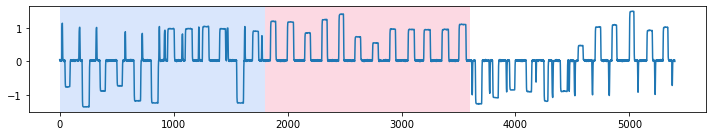

In [58]:
filepath = './datasets/UMD/UMD_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)
print(df)
print(df.shape)

# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*150))
    l_p = p

rpt.display(ndarray.flatten(), change_points)

result,eval =  predict_change_points(ndarray.flatten(),len(ndarray.flatten()),change_points)
rpt.display(ndarray.flatten(), change_points,result)
eval

5400
[1. 1. 1. ... 1. 1. 1.]
[4400 1609]


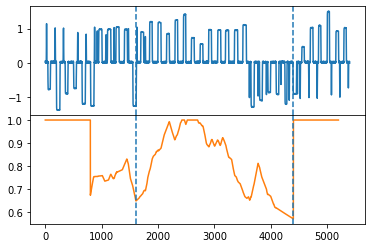

In [59]:
data = ndarray.flatten().transpose().astype(np.float64)

m = 200
mp = stumpy.stump(data, m=m)

L = 200
cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=3, excl_factor=4)
print(len(data))

print(cac)
print(regime_locations)
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(range(data.shape[0]), data)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")

axs[0].axvline(x=regime_locations[1], linestyle="dashed")
axs[1].axvline(x=regime_locations[1], linestyle="dashed")


plt.show()

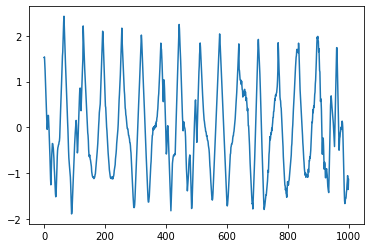

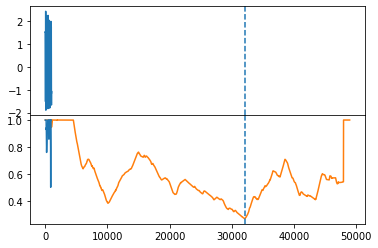

In [57]:
filepath = './datasets/SwedishLeaf/SwedishLeaf_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)


# Konwersja dataframe na ndarray
ndarray = df.values
ch = ndarray[:,-1]
ndarray = ndarray[:, :-1]
# Alternatywnie można użyć .to_numpy() w nowszych wersjach Pandas
# ndarray = df.to_numpy()

change_points = np.array([],dtype=int)
l_p = ch[0]
for i, p in enumerate(ch):
    if(p!=l_p):
        change_points = np.append(change_points,int(i*128))
    l_p = p

#rpt.display(ndarray.flatten()[0:1590], change_points[:4])

data = ndarray.flatten().transpose().astype(np.float64)
data = data[:1000]
plt.plot(data)

m = 64
mp = stumpy.stump(data, m=m)

L = 64
# cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=15, excl_factor=1)

# fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
# axs[0].plot(range(data.shape[0]), data)
# axs[0].axvline(x=regime_locations[0], linestyle="dashed")
# axs[1].plot(range(cac.shape[0]), cac, color='C1')
# axs[1].axvline(x=regime_locations[0], linestyle="dashed")

# axs[0].axvline(x=regime_locations[1], linestyle="dashed")
# axs[1].axvline(x=regime_locations[1], linestyle="dashed")


# plt.show()

cac_1d = _cac(mp[:, 3], L, bidirectional=False, excl_factor=1) 
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(np.arange(data.shape[0]), data)
axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
axs[1].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac_1d.shape[0]), cac_1d)
plt.show()

# Load Cricket

1197
(6,)
6
(129276, 6)
[ 10773  21546  32319  43092  53865  64638  75411  86184  96957 107730
 118503]


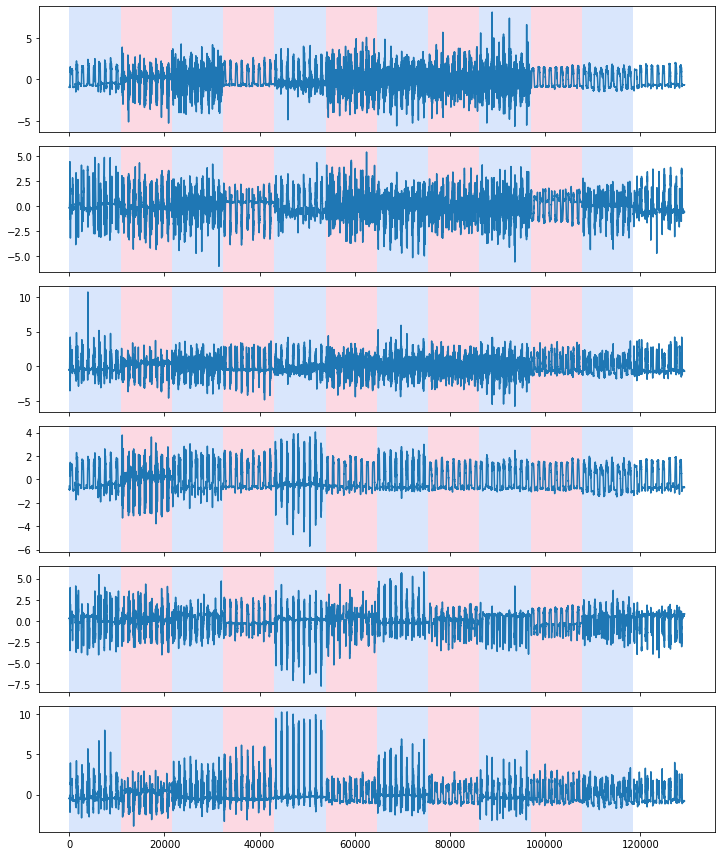

In [217]:
filepath = './datasets/Cricket/Cricket_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)

print(len(df.iloc[0,0][0]))

cricet_stacked,ch  = stack_time_series_randomly(df,False)
cricet_stacked_ndarray = dataframe_to_ndarray(cricet_stacked)
ch = ch.astype(dtype = int )
# #print(df.iloc[0,0][0])
# print(heart_stacked_ndarray)
print(cricet_stacked_ndarray.shape)

# print(type(df.iloc[0,0][0]) == np.void)
rpt.display(cricet_stacked_ndarray, ch)
print(ch)

In [10]:
data = cricet_stacked_ndarray.astype(np.float64)
data = data[:50000] 

[[-0.97211 -0.23077 -0.46863 -0.57729  0.29993 -0.44158]
 [-0.95768 -0.23077 -0.43983 -0.75975  0.31719 -0.40136]
 [-0.95901 -0.23077 -0.45135 -0.8011   0.33099 -0.39331]
 ...
 [-0.65868 -0.51648 -0.5336  -0.48116  0.16418 -0.2659 ]
 [-0.4251  -0.51648 -0.73889 -0.48116  0.16418 -0.2597 ]
 [-0.65868 -0.58247 -0.5336  -0.48116  0.17465 -0.2597 ]]


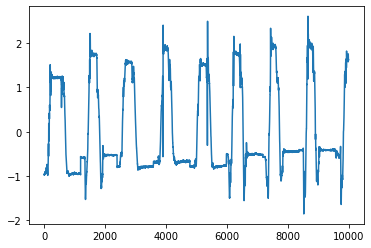

In [11]:
print(data)
plt.plot(data[:10000,0])
data = data[:,0]

[-0.97211 -0.95768 -0.95901 ... -0.65868 -0.4251  -0.65868]
[32101 31100 30099 29098]
<class 'numpy.ndarray'>


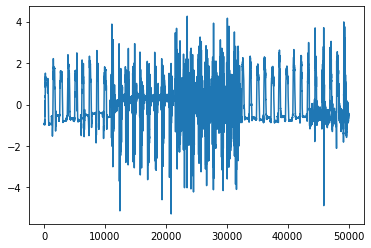

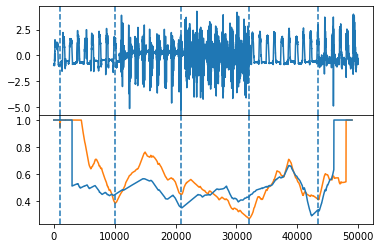

In [17]:
import pandas as pd
import numpy as np
import stumpy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import animation
from IPython.display import HTML
from stumpy.floss import _cac
from scipy.signal import argrelextrema

#help(stumpy.fluss)
plt.plot(data)
print(data)

m = 1000
mp = stumpy.stump(data, m=m)

L = 1000


cac, regime_locations = stumpy.fluss(mp[:, 1], L=L, n_regimes=5, excl_factor=1)


print(regime_locations)
fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
axs[0].plot(range(data.shape[0]), data)
# axs[0].axvline(x=regime_locations[0], linestyle="dashed")
axs[1].plot(range(cac.shape[0]), cac, color='C1')
# axs[1].axvline(x=regime_locations[0], linestyle="dashed")

# axs[0].axvline(x=regime_locations[1], linestyle="dashed")
# axs[1].axvline(x=regime_locations[1], linestyle="dashed")

# axs[0].axvline(x=regime_locations[2], linestyle="dashed")
# axs[1].axvline(x=regime_locations[2], linestyle="dashed")


# axs[0].axvline(x=regime_locations[3], linestyle="dashed")
# axs[1].axvline(x=regime_locations[3], linestyle="dashed")

cac_1d = _cac(mp[:, 3], L, bidirectional=True, excl_factor=3)  # This is for demo purposes only. Use floss() below!


axs[1].plot(range(cac_1d.shape[0]), cac_1d)
order = 3000


local_minima_indices = argrelextrema(cac, np.less, order=order)[0]


for i in local_minima_indices:
    axs[0].axvline(x=i, linestyle="dashed")
    axs[1].axvline(x=i, linestyle="dashed")

print(type(cac))
plt.show()

In [60]:
help(stumpy.floss)

Help on class floss in module stumpy.floss:

class floss(builtins.object)
 |  floss(mp, T, m, L, excl_factor=5, n_iter=1000, n_samples=1000, custom_iac=None, normalize=True, p=2.0, T_subseq_isconstant_func=None)
 |  
 |  A class to compute the Fast Low-cost Online Semantic Segmentation (FLOSS) for
 |  streaming data
 |  
 |  Parameters
 |  ----------
 |  mp : numpy.ndarray
 |      The first column consists of the matrix profile, the second column
 |      consists of the matrix profile indices, the third column consists of
 |      the left matrix profile indices, and the fourth column consists of
 |      the right matrix profile indices.
 |  
 |  T : numpy.ndarray
 |      A 1-D time series data used to generate the matrix profile and matrix profile
 |      indices found in ``mp``. Note that the the right matrix profile index is used
 |      and the right matrix profile is intelligently recomputed on the fly from ``T``
 |      instead of using the bidirectional matrix profile.
 |  
 |  m

In [67]:
help(argrelextrema)

Help on function argrelextrema in module scipy.signal._peak_finding:

argrelextrema(data, comparator, axis=0, order=1, mode='clip')
    Calculate the relative extrema of `data`.
    
    Parameters
    ----------
    data : ndarray
        Array in which to find the relative extrema.
    comparator : callable
        Function to use to compare two data points.
        Should take two arrays as arguments.
    axis : int, optional
        Axis over which to select from `data`. Default is 0.
    order : int, optional
        How many points on each side to use for the comparison
        to consider ``comparator(n, n+x)`` to be True.
    mode : str, optional
        How the edges of the vector are treated. 'wrap' (wrap around) or
        'clip' (treat overflow as the same as the last (or first) element).
        Default is 'clip'. See `numpy.take`.
    
    Returns
    -------
    extrema : tuple of ndarrays
        Indices of the maxima in arrays of integers. ``extrema[k]`` is
        the

# Fluss

5000


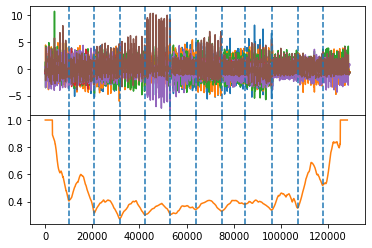

In [131]:
import pandas as pd
import numpy as np
import stumpy
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle, FancyArrowPatch
from matplotlib import animation
from IPython.display import HTML
from stumpy.floss import _cac
from scipy.signal import argrelextrema


def get_indices_matricies(data,m):
    mp = stumpy.stump(data, m)
    return mp[:, 1] 
        
def get_cac_curves(mpi,L,n_regimes,exclusion_factor):
    cac, regime_locations = stumpy.fluss(mpi, L=L, n_regimes=n_regimes, excl_factor=exclusion_factor)
    return cac

class Fluss:
    def __init__(self,L,exclusion_factor,n_regimes):
        self.L=L
        self.exclusion_factor=exclusion_factor
        self.n_regimes=n_regimes
        self.custom_extraction = False
        self.custom_extraction_zone = 5*L 
        self.last_regimes = None
        self.last_cac = None
        self.last_data = None
        
    def turn_custom_regime_extraction(self, extraction_zone = None):
        self.custom_extraction = True
        if extraction_zone is not None:
            self.custom_extraction_zone = extraction_zone 
        
    def predict_regimes(self,data):
        self.last_data = data
        mp = stumpy.stump(data, m=self.L)
        cac, regime_locations = stumpy.fluss(mp[:, 1], L=self.L, n_regimes=self.n_regimes, excl_factor=self.exclusion_factor)
        self.last_cac = cac
        
        if(self.custom_extraction):
            print(self.custom_extraction_zone)
            local_minima_indices = argrelextrema(cac, np.less, order=self.custom_extraction_zone)[0]
            self.last_regimes = local_minima_indices
            return cac, local_minima_indices
        else:
            self.last_regimes = regime_locations
            return cac, regime_locations
    
    def m_predict_regimes(self,data):
        self.last_data = data
        m_mp = np.apply_along_axis(get_indices_matricies, 0, data,self.L)
        m_cac = np.apply_along_axis(get_cac_curves, 0, m_mp,self.L,self.n_regimes,self.exclusion_factor)
        mean_cac = np.mean(m_cac, axis=1)

        self.last_cac = mean_cac
        
        if(self.custom_extraction):
            print(self.custom_extraction_zone)
            local_minima_indices = argrelextrema(mean_cac, np.less, order=self.custom_extraction_zone)[0]
            self.last_regimes = local_minima_indices
            return mean_cac,m_cac, local_minima_indices
        else:
            return -1
            
    def print_latest_output(self):
        fig, axs = plt.subplots(2, sharex=True, gridspec_kw={'hspace': 0})
        axs[0].plot(range(self.last_data.shape[0]), self.last_data)
        axs[1].plot(range(self.last_cac.shape[0]), self.last_cac, color='C1')
        
        for i in self.last_regimes:
            axs[0].axvline(x=i, linestyle="dashed")
            axs[1].axvline(x=i, linestyle="dashed")
        plt.show()

    def turn_original_extraction(self):
        self.custom_extraction = False

            

FlussRegimeSegmentator = Fluss(1000,3,5)
FlussRegimeSegmentator.turn_custom_regime_extraction()
# cac , regimes = FlussRegimeSegmentator.predict_regimes(data)
# FlussRegimeSegmentator.print_latest_output()

m_data = cricet_stacked_ndarray.astype(np.float64)
cac , m_cac ,regimes = FlussRegimeSegmentator.m_predict_regimes(m_data)
FlussRegimeSegmentator.print_latest_output()


In [253]:
def get_evaluation(result,original_points,n):
    prediction_margin =( n/len(original_points)/8)
    print(prediction_margin)
    TP,TN,FP,FN = calculate_TP_TN_FP_FN(n,result,original_points,prediction_margin)
    ASC = calculateASC(n,result,original_points,prediction_margin)
    ASD = calculateASD(n,result,original_points,prediction_margin)
    ADT = calculateADT(n,result,original_points,prediction_margin)
        
    Acc, Prec, Recall, F1 = calculate_ACC_PRE_REC_F1(TP,TN,FP,FN)
    #score = ScoreRegimes(result,original_points,n)
        
        # Dane
    etykiety = ["Acc", "Prec", "Recall", "F1","ASC","ASD","ADT"]
    wartosci = [Acc, Prec, Recall, F1 , ASC , ASD, ADT]
        
        # Tworzenie DataFrame
    evaluation = pd.DataFrame({
            "Metryka": etykiety,
            "Wartość": wartosci
        })
    return evaluation
eval = get_evaluation(regimes,ch,129276)

def ScoreRegimes(locRegimes, gtRegimes, ts_length):
    """
    Function to score the difference between extracted regimes and ground truth regimes.

    Parameters:
    locRegimes (list or np.array): extracted regimes
    gtRegimes (list or np.array): ground truth regimes
    ts_length (int): length of the time series

    Returns:
    float: score in the range [0, 1], with 0 being the best score
    """
    sumDiff = 0
    numRegimes = len(gtRegimes)

    for i in range(numRegimes):
        # Find the gtRegimes[j] closest to locRegimes[i]
        closest_diff = min(abs(locRegime - gtRegimes[j]) for j, locRegime in enumerate(locRegimes))
        sumDiff += closest_diff

    score = sumDiff / ts_length
    return score

eval

1469.0454545454545


,Metryka,Wartość
0,Acc,1.000000
1,Prec,1.000000
2,Recall,1.000000
3,F1,1.000000
4,ASC,1.000000
5,ASD,763.909091
6,ADT,0.000000


# BottomUp in Cricket

[ 10773  21546  32319  43092  53865  64638  75411  86184  96957 107730
 118503]


C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


11
1469.0454545454545
[7870, 8500, 20420, 32940, 43090, 53865, 66610, 75410, 96960, 107315, 118615, 129276]
[7870, 8500, 20420, 32940, 43090, 53865, 66610, 75410, 96960, 107315, 118615, 129276]


,Metryka,Wartość
0,Score,0.000255
1,Acc,0.999938
2,Prec,0.727273
3,Recall,0.727273
4,F1,0.727273
5,ASC,0.727273
6,ASD,285.000000
7,ADT,0.375000


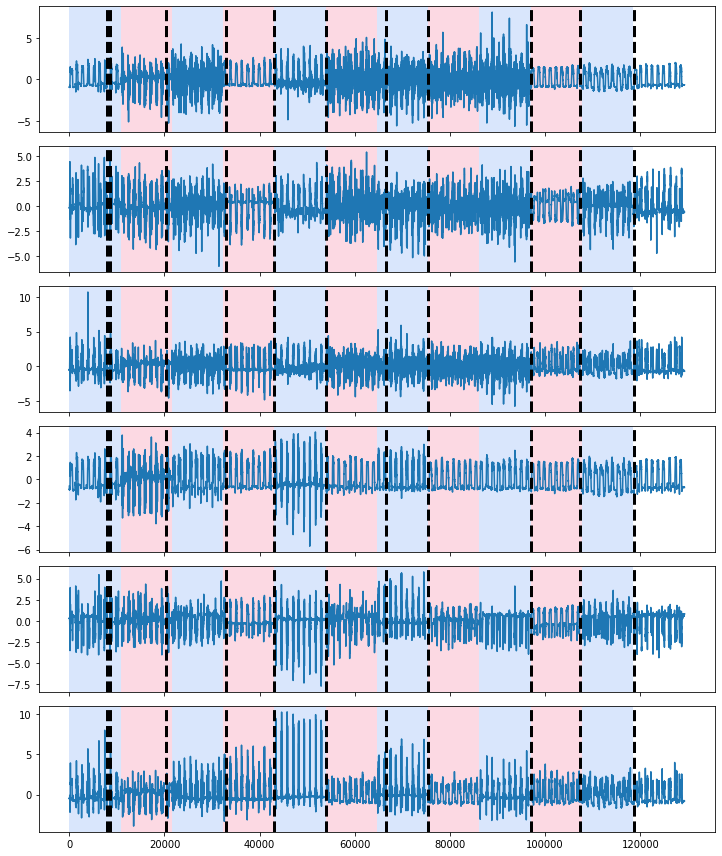

In [220]:
print(ch)
eval,result = predict_change_points(m_data,129276,ch,"normal")

rpt.display(m_data,ch,result)
print(result)
eval



In [216]:
help(rpt.display)

Help on function display in module ruptures.show.display:

display(signal, true_chg_pts, computed_chg_pts=None, computed_chg_pts_color='k', computed_chg_pts_linewidth=3, computed_chg_pts_linestyle='--', computed_chg_pts_alpha=1.0, **kwargs)
    Display a signal and the change points provided in alternating colors.
    If another set of change point is provided, they are displayed with dashed
    vertical dashed lines. The following matplotlib subplots options is set by
    default, but can be changed when calling `display`):
    
    - figure size `figsize`, defaults to `(10, 2 * n_features)`.
    
    Args:
        signal (array): signal array, shape (n_samples,) or (n_samples, n_features).
        true_chg_pts (list): list of change point indexes.
        computed_chg_pts (list, optional): list of change point indexes.
        computed_chg_pts_color (str, optional): color of the lines indicating
            the computed_chg_pts. Defaults to "k".
        computed_chg_pts_linewidth (in

# Fluss in SweadishLeafs

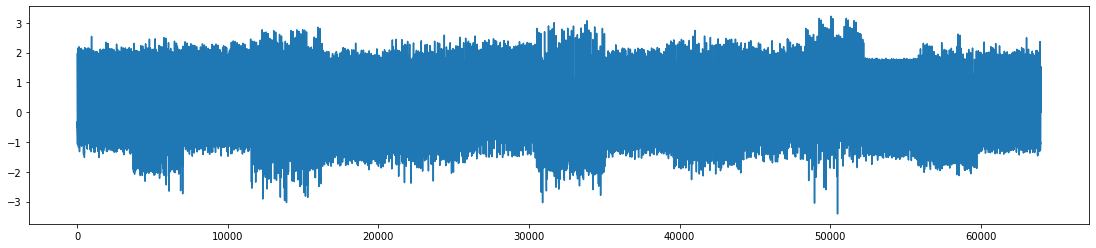

640


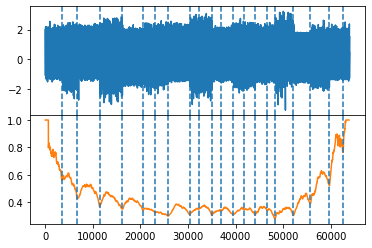

64000
[ 3712  7040 11520 16384 20608 25984 30464 35072 39552 44160 48384 52224
 55808 59776]
[ 3498  6707 11411 16200 20540 23106 25755 30385 32287 35066 36877 39523
 41873 44135 46665 48319 52182 55756 59757 62588]
571.4285714285714


,Metryka,Wartość
0,Acc,0.999875
1,Prec,0.700000
2,Recall,1.000000
3,F1,0.823529
4,ASC,1.000000
5,ASD,103.857143
6,ADT,0.000000


In [255]:
filepath = './datasets/SwedishLeaf/SwedishLeaf_TRAIN.arff'
def loadSweadishLeafsWithRegimes(filepath):
    df = load_dataset_to_dataframe(filepath)
    # mask = df['target'].values == b'4'
    # mask1 = df['target'].values == b'11'
    # ndarray = df.values[mask]
    # ndarray1 = df.values[mask1]
    # sw_leaf_data = np.concatenate((ndarray[:,:-1].flatten()[:1500], ndarray1[:,:-1].flatten()[:1500])).astype(dtype=float)
    original_points = np.array([])
    data = np.array([])
    groups = df.groupby('target')

    # Iteracja po grupach
    sum = 0 
    for name, group in groups:
        #print(f"Grupa: {name}")
        #print(group.shape[0])
        #print(group)
        data = np.concatenate((data, group.values[:,:-1].flatten())).astype(dtype=float)
        original_points = np.append(original_points, sum + group.shape[0]*( group.shape[1]-1))
        sum += group.shape[0]*( group.shape[1]-1)
    return data, original_points[:-1].astype(dtype = int)
    




sw_leaf_data, original_points = loadSweadishLeafsWithRegimes(filepath)

fig, ax = plt.subplots(figsize=(19, 4))  # width=10 inches, height=6 inches
ax.plot(sw_leaf_data)
plt.show()

sw_fluss = Fluss(128,5,1)
sw_fluss.turn_custom_regime_extraction()

cac, regime_locations = sw_fluss.predict_regimes(sw_leaf_data)
sw_fluss.print_latest_output()
print(len(sw_leaf_data))
print(original_points)
print(regime_locations)
eval = get_evaluation(regime_locations,original_points,len(sw_leaf_data))
eval

# BottomUp in SWLeafs

C:\Users\Damian\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\ruptures\costs\costnormal.py:27: UserWarning: New behaviour in v1.1.5: a small bias is added to the covariance matrix to cope with truly constant segments (see PR#198).
  warnings.warn(


14
571.4285714285714
[14605, 14640, 45390, 45415, 47380, 47405, 50060, 50095, 51145, 51190, 57320, 57365, 57835, 57880, 64000]
[14605, 14640, 45390, 45415, 47380, 47405, 50060, 50095, 51145, 51190, 57320, 57365, 57835, 57880, 64000]


,Metryka,Wartość
0,Score,0.414750
1,Acc,0.999417
2,Prec,0.000000
3,Recall,0.000000
4,F1,0.000000
5,ASC,0.000000
6,ASD,-1.000000
7,ADT,-1.000000


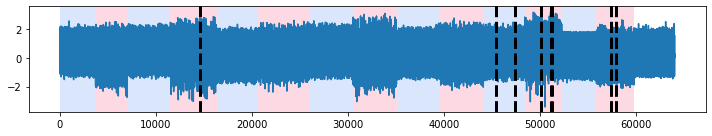

In [263]:

eval,result = predict_change_points(sw_leaf_data,len(sw_leaf_data),original_points,"normal")

rpt.display(sw_leaf_data,original_points,result)
print(result)
eval



# Fluss in Cricket

In [112]:
filepath = './datasets/Cricket/Cricket_TRAIN.arff'

df = load_dataset_to_dataframe(filepath)

print(len(df.iloc[0,0][0]))

cricet_stacked,ch  = stack_time_series_randomly(df,False)
cricet_stacked_ndarray = dataframe_to_ndarray(cricet_stacked)

# #print(df.iloc[0,0][0])
# print(heart_stacked_ndarray)
print(cricet_stacked_ndarray.shape)
# plt.plot(cricet_stacked_ndarray[:,0])
# print(type(df.iloc[0,0][0]) == np.void)
#rpt.display(cricet_stacked_ndarray, ch)

m_data = cricet_stacked_ndarray.astype(np.float64)
m_data = m_data[:50000,:]
FlussRegimeSegmentator = Fluss(1000,3,5)
cac , m_cac ,regimes = FlussRegimeSegmentator.m_predict_regimes(m_data)
FlussRegimeSegmentator.print_latest_output()


1197
(6,)
6
(129276, 6)


TypeError: cannot unpack non-iterable int object